# Exploratory Data Analysis

Juan Lopez Martin

## 1. Loading dataset

We load the dataset, remove all the rows that do not contain a narrative and take a random sample of 100,000.

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
from operator import itemgetter

In [11]:
df = pd.read_csv("Consumer_Complaints.csv")

C:\Users\Juanl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
df = df.dropna(subset=['Consumer complaint narrative'])
#df['Date received'] = pd.to_datetime(df['Date received'], format = '%m/%d/%Y')
df = df.set_index("Complaint ID")

In [13]:
df = df.sample(100000)

## 2. Taking a look at the issues

First, we look at the most frequent issues.

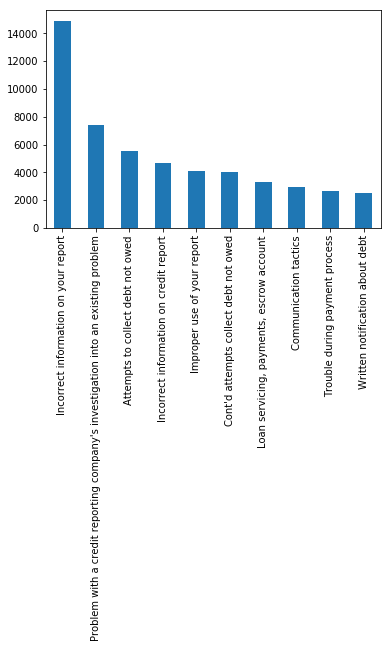

In [72]:
df['Issue'].value_counts()[0:10].plot.bar()

Something that immediatelly comes to mind is that some of the issues look very similar. The goal of this small exploration is to study if there are commonalities on the narratives between issues. We would expect, for instance, that the narratives of the first and fourth most frequent issue will be quite similar.

## 3. Using LDA to see commonalities in the issues

One way to test this intuition requires:

1. Using LDA to cluster narratives into topics. LDA gives a estiamte of the presence of each topic in each narrative. However, and for simplicity, we just considered the most present topic in each narrative. That is, for each narrative we extracted the most present topic.
2. We would expect that two similar issues would have corresponding narratives clustered into the same topic. Conversely, if two  issues were radically different we expect that their narratives reflected different topics.

### 3.1 Data cleaning

We used SpaCy for data cleaning. Steps:
* Filter out all the words that were not alphanumeric
* Get rid of stopwords, spaces, punctuation marks, and numbers
* Removed XX, XXX, XX/XX, etc.
* Lemmatization

In [14]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [65]:
# Unoptimized version
# def process_sentence(sentence):
#     sent_spacy = nlp(sentence.lower())
#     sent = [word.lemma_ for word in sent_spacy if not word.is_stop and not word.is_punct and not word.like_num and word.text not in xs]
#     return sent

In [15]:
xs = ["X"*2, "X"*3, "X"*4, "X"*5, "X"*6, "X"*7, "X"*8, "X"*9, "X"*10, "X"*11, "XX/XX", "XX/XX/XXX", "XX/XX/XX", "XX/XXXX"]

texts = []
for sent in nlp.pipe(df['Consumer complaint narrative'], disable=["tagger", "parser", "ner", "textcat"]):
    texts.append([word.lemma_ for word in sent 
                  if word.is_alpha and
                  not word.is_space and
                  not word.is_stop and 
                  not word.is_punct and 
                  not word.like_num and 
                     word.text not in xs])

In [40]:
texts[0][0:8]

['REVIEWING',
 'CREDIT',
 'REPORT',
 'MONTH',
 'IDENTIFIED',
 'INACCURATE',
 'ITEMS',
 'PLACED']

In [17]:
#filetosave1 = open("texts.pyobject", 'wb')
#pickle.dump(texts, filetosave1)

#filetosave2 = open("df.pyobject", "wb")
#pickle.dump(df, filetosave2)

In [17]:
#filetoread1 = open("texts.pyobject", 'rb')
#texts = pickle.load(filetoread1)

#filetoread2 = open("df.pyobject", 'rb')
#df = pickle.load(filetoread2)

### 3.2 LDA

Gensim was used for creating bigrams and then for topic modeling.

In [18]:
from gensim.models import Phrases
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel, LdaModel
from gensim.corpora import Dictionary

In [19]:
bigram = Phrases(texts)
text_bigrams = bigram[texts]

In [20]:
dictionary = Dictionary(text_bigrams)
corpus = [dictionary.doc2bow(text) for text in text_bigrams]

In [21]:
ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5)

In [39]:
#filetosave3 = open("dictionary.pyobject", 'wb')
#pickle.dump(dictionary, filetosave3)
#filetosave3 = open("dictionary.pyobject", 'rb')
#pickle.load(dictionary, filetosave3)

#filetosave4 = open("corpus.pyobject", "wb")
#pickle.dump(corpus, filetosave4)
#filetosave4 = open("corpus.pyobject", "rb")
#pickle.load(corpus, filetosave4)

#filetosave5 = open("ldamodel.pyobject", "wb")
#pickle.dump(ldamodel, filetosave5)
#filetosave5 = open("ldamodel.pyobject", "rb")
#pickle.load(ldamodel, filetosave5)

In [22]:
topics = [max(x,key=itemgetter(1))[0] for x in ldamodel[corpus]]
df['Topics'] = topics

### 3.3 Results

In the next plot we see how different issues contain narratives that were assigned to the 5 topics considered at different rates. For instance, we see that narratives in the "loan servicing, payments, escrow account" were most frequently clustereed in the topic 0.

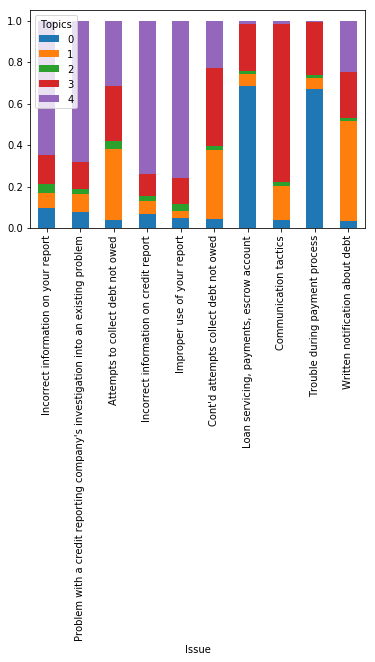

In [74]:
issues_considered = list(df['Issue'].value_counts()[0:10].index)
newdf = df[df['Issue'].isin(issues_considered)]
ct = pd.crosstab(newdf['Issue'],df['Topics'])
ctp = ct.apply(lambda x: x/x.sum(), axis = 1)
ctp.loc[list(newdf['Issue'].value_counts().index)].plot.bar(stacked = True)

#ctp['Max'] = ctp[ctp.columns].idxmax(axis=1)
#ctp['Max'].sort_values()

The clustering makes sense, and we can actually which issues are related to which. Based on the issue names and the topics we can name 4 of the LDA topics:

* Topic 0: I have to pay but I have trouble with the payment
* Topic 1: I have received a notification about debt that I do not seem to owe
* Topic 3: People are calling me excessively (maybe to collect debt?)
* Topic 4: I have trouble with credit reporting

## Trash

In [146]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [177]:
df.groupby('Company')['Timely response?']

In [176]:
pd.DataFrame([df['Company'].value_counts(), df.groupby('Company')['Timely response?'].count()])

,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Experian Information Solutions Inc.,"EQUIFAX, INC.","CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION",WELLS FARGO & COMPANY,SYNCHRONY FINANCIAL,CAPITAL ONE FINANCIAL CORPORATION,JPMORGAN CHASE & CO.,"Navient Solutions, LLC.",...,Professional Receivables Network,"DIRECMANAGEMENT, INC.","American Financial Resources, Inc.",Audit & Adjustment Co. Inc.,"United Check Recovery Bureau, Inc.","Blakely-Witt and Associates, Inc.","UNITED BANKSHARES, INC.","JP RECOVERY SERVICES, INC.","Atlantic Union Bankshares, Inc.","Michigan Mutual, Inc."
Company,5836,4790,3900,1062,934,912,806,734,692,427,...,1,1,1,1,1,1,1,1,1,1
Timely response?,5836,4790,3900,1062,934,912,806,734,692,427,...,1,1,1,1,1,1,1,1,1,1


In [144]:
k1 = df[df['Timely response?']=='No']['Company'].value_counts()
k2 = df['Company'].value_counts()

pd.Series([k1, k2])

0    WELLS FARGO & COMPANY                        3...
1    TRANSUNION INTERMEDIATE HOLDINGS, INC.        ...
dtype: object

In [50]:
#df['Issue'].value_counts()

In [51]:
#df['Sub-issue'].value_counts()

In [ ]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

In [54]:
#df['Consumer complaint narrative'].value_counts()

In [60]:
df['Company response to consumer'].value_counts()

Closed with explanation            6211
In progress                        2775
Closed with non-monetary relief     754
Closed with monetary relief         195
Untimely response                    65
Name: Company response to consumer, dtype: int64

In [69]:
df['Company public response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            17992
Company believes it acted appropriately as authorized by contract or law                                                    2120
Company believes the complaint is the result of a misunderstanding                                                           213
Company disputes the facts presented in the complaint                                                                        154
Company believes complaint is the result of an isolated error                                                                108
Company believes complaint caused principally by actions of third party outside the control or direction of the company      105
Company believes complaint represents an opportunity for improvement to better serve consumers                                80
Company can't verify or dispute the facts in the complaint                                       

In [70]:
df['Company'].value_counts()[0:10]

TRANSUNION INTERMEDIATE HOLDINGS, INC.    5836
Experian Information Solutions Inc.       4790
EQUIFAX, INC.                             3900
CITIBANK, N.A.                            1062
BANK OF AMERICA, NATIONAL ASSOCIATION      934
WELLS FARGO & COMPANY                      912
SYNCHRONY FINANCIAL                        806
CAPITAL ONE FINANCIAL CORPORATION          734
JPMORGAN CHASE & CO.                       692
Navient Solutions, LLC.                    427
Name: Company, dtype: int64

In [87]:
from gensim.summarization import summarize

In [92]:
df['Consumer complaint narrative'].map(lambda x: len(x)).mean()

1065.3341769206156

In [86]:
summarize('These collection agencies are reporting debt with changed starting dates. Two debts sold to these companies and they changed the dates of the debt from being several years old to just months old. They are cheating and lying by entering incorrect debt starting dates.')

''

In [117]:
df['Consumer complaint narrative'].iloc[10].replace('. ', '\n')

"this is the final complaint that I am going to issue before going to FBI/ oh attorney general 's office about this company XXXX XXXX who keeps committing a crime against me by refusing to update XXXX XXXX XXXX XXXX who was the Creditors info the credit union has sent to XXXX XXXX a total of 3 TIMES! XXXX stress that XXXX XXXX continues to ignore XXXX 's request in WRITTING to mark item PAID in full that is reflecting bad negative item on my credit report! \nI WILL NOT STAND FOR THIS\nIT IS COMING TO CIVIL litigation SO BE IT! I NEED THIS TO STOP! THIS IS TOTAL DISCRIMINATION AGAINST me! XXXX XXXX once again for the third 3rd time!!!! is refusing to HONOR XXXX XXXX XXXX request in writing\nXXXX has informed me mass times by phone and via email ( evidence attached ) that they have contact XXXX XXXX XXXX XXXX to let them know thousands of time to make a issue that was solved between the credit union and I PAID request to update my file mass times which is hurting me from opening bank acc

In [126]:
print(summarize(df['Consumer complaint narrative'].iloc[5].replace('. ', '[.]\n')))

I was sitting at home and I receive an alert that my credit report changed on Transunion, I looked immediately on XX/XX/2019 right away, my credit card shows Chapter XXXX Bankruptcy, I never filed bankruptcy, I am current with my payments, have never been late[.]


In [109]:
print(summarize('''
These collection agencies are reporting debt with changed starting dates. 
Two debts sold to these companies and they changed the dates of the debt from being several years old to just months old. 
They are cheating and lying by entering incorrect debt starting dates.
'''))

In [112]:
text = '''These collection agencies are reporting debt with changed starting dates
... Two debts sold to these companies and they changed the dates of the debt from being several years old to just months old
... They are cheating and lying by entering incorrect debt starting dates
'''
print(summarize(text))